<a href="https://colab.research.google.com/github/DS-Jerry-in-Taiwan/project-set/blob/main/trees_based_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 鳶尾花資料集 & Tree-Based Algorithms

<font size=3>https://reurl.cc/xZ5gb1</font>

scikit-learn 所提供的分類器裏面，最簡單的就是決策樹，但是使用決策樹雖然簡單，呈現決策樹卻不是很容，畢竟不是每個人都可以掌握把決策樹在簡報上畫得漂漂亮亮的技巧。

本單元介紹幾種不同的輸出技巧，
我們可以用 sklearn 的 plot_tree，或者是 **graphiviz** 工具，也可以用 [dtreeplt](https://pypi.org/project/dtreeplt/) 套件來繪製決策樹圖形。

如果要使用 dtreeplt 或 graphviz ，使用前記得要先導入（import）套件。

這個模組的後半部，會從單一的樹延伸到隨機森林等 ensemble learning 演算法。


```
!pip3 install graphviz
!pip3 install dtreeplt
```

# 1 Imoporting libraries

## 1.1 載入常用套件以及常數定義 ✔

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/MyDrive/adventure_time/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventure_time/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/tree/'
data_dir = groot_dir + 'tree/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def start_plot_hires(figsize=(10, 8), style = 'whitegrid', dpi = 300):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nLibraries and dependenciess imported')
print_now()

Mounted at /content/drive

Running on linux
Python Version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Data storage points to ==> /content/drive/MyDrive/adventure_time/tree/

Libraries and dependenciess imported
2021-12-25 15:33:52.015286


# 2 Explore Iris Dataset

參考連結

- [scikit-learn datasets loaders](https://scikit-learn.org/stable/modules/classes.html?highlight=datasets#module-sklearn.datasets)
- [7. Dataset loading utilities](https://scikit-learn.org/stable/datasets/index.html#datasets)
- [7.2.2. Iris plants dataset](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)
- [Kaggle Dataset](https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms)
- [機器學習資料集/ 範例三: The iris dataset](https://machine-learning-python.kspax.io/datasets/ex3_the_iris_dataset)


## 2.1 如何取得 iris 資料集

原始資料有兩個來源：

- [UCI Machine Learning Reposiotory (https://archive.ics.uci.edu/ml/datasets/iris)](https://archive.ics.uci.edu/ml/datasets/iris)
- [scikit-learn.datasets.load_iris()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris)


## 2.2 load_iris & 欄位名稱

所有 sklearn [load_XXXX](https://scikit-learn.org/stable/datasets/index.html) 函式載入的資料，資料集結構 不是 Pandas DataFrame，是另外一種資料結構叫 BUNCH，，不能用 info 或 describe 方法看資料細節。BUNCH 要用下列方式，觀察欄位結構，下載資料主要是兩部分： data & target，兩者都是 numpy 定義的 **ndarray** 結構。:

```
from sklearn.datasets import load_iris
iris = load_iris()
for key,value in iris.items() :
    try:
        print (key,value.shape)
    except:
        print (key)
print(iris['feature_names'])
```

In [ ]:
from sklearn.datasets import load_iris

#load iris data from scikit_learn package
iris_raw = load_iris()

print(type(iris_raw))#default data type is Bunch
print(type(iris_raw.data))
print(type(iris_raw.target))
print('--------')

#check key and value shape of data inside the iris_raw
for key,value in iris_raw.items() :
    try:
        print (key,value.shape)
    except:
        print (key)
print(iris_raw['feature_names'])
print(iris_raw['target_names'])

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
--------
data (150, 4)
target (150,)
frame
target_names (3,)
DESCR
feature_names
filename
data_module
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [ ]:
#upgrade package
!pip install scikit-learn --upgrade
#check package version
n=sklearn.__version__
print(n)

1.0.1


0.24.2


In [ ]:
# features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
#make sure the version of scikitlearn is beyond 0.23
assert sklearn.__version__ >= '0.23'
from sklearn.datasets import load_iris

iris = load_iris(as_frame = True)
print(type(iris))
X_iris = iris.data
y_iris = iris.target

X_iris=X_iris.assign(target=iris.target)
print(X_iris.columns)
# print(iris)
# for key,value in iris.items():
#   print(key,':',value.shape)

type(X_iris), type(y_iris), X_iris.head(), y_iris.head()

<class 'sklearn.utils.Bunch'>
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')


(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
    sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
 0                5.1               3.5  ...               0.2       0
 1                4.9               3.0  ...               0.2       0
 2                4.7               3.2  ...               0.2       0
 3                4.6               3.1  ...               0.2       0
 4                5.0               3.6  ...               0.2       0
 
 [5 rows x 5 columns],
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: target, dtype: int64)

## 2.3 iris dataset 的欄位解讀

- sepal length in cm 花萼
- sepal width in cm
- petal length in cm 花瓣
- petal width in cm
- class: （物種）

    - Iris-Setosa

    - Iris-Versicolour

    - Iris-Virginica

欄位的意義，可參考[欄位中文解釋](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC2-1%E8%AC%9B-%E5%A6%82%E4%BD%95%E7%8D%B2%E5%8F%96%E8%B3%87%E6%96%99-sklearn%E5%85%A7%E5%BB%BA%E8%B3%87%E6%96%99%E9%9B%86-baa8f027ed7b)、[解釋二](https://machine-learning-python.kspax.io/datasets/ex3_the_iris_dataset)與[解釋三](https://hackmd.io/@mutolisp/SyowFbuAb?type=view)，解釋二使用 [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) 將數據降維，是資料降維的技巧。

```
X_reduced = PCA(n_components=3).fit_transform(iris.data)

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()
```
- Original [UCI Archive](http://archive.ics.uci.edu/ml/datasets/Iris)
- https://adityashrm21.github.io/Decision-Trees/
- https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952
- https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

下面的圖形，說明鳶尾花資料各欄位的意義

![](https://i.imgur.com/D3GcNNH.jpg)

## 2.4 Visualizing Iris Datasets

- Pandas [Visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) Guide
- [Seaborn Matplotlib plot to visualize Iris data](https://www.kaggle.com/biphili/seaborn-matplotlib-plot-to-visualize-iris-data)


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


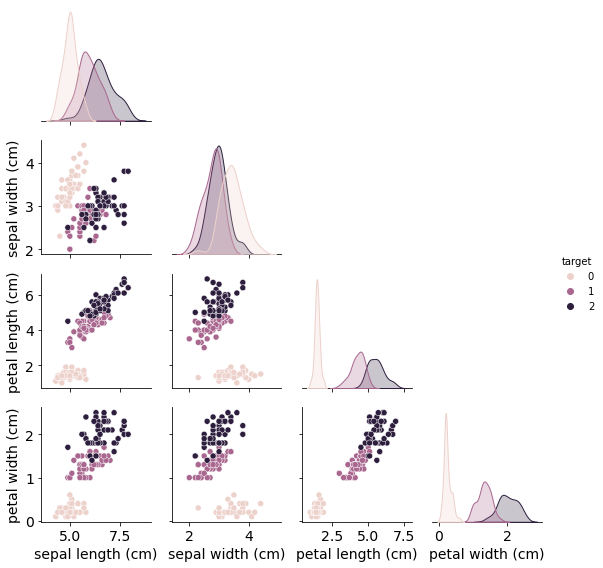

In [ ]:
# sns.pairplot(iris, hue='target', size=2, aspect=1)
#hue=column to categorize
sns.pairplot(X_iris, hue='target',size=2,aspect=1,corner=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


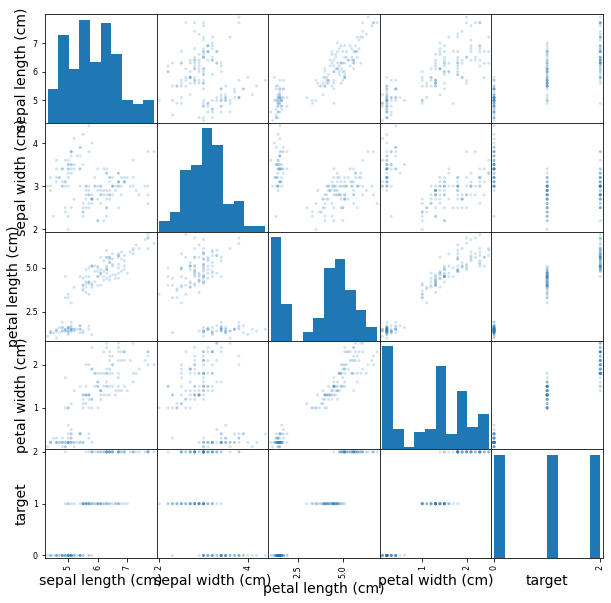

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
pd.plotting.scatter_matrix(X_iris, alpha = 0.2, ax = ax)
plt.show()

# 3 Decision Tree

- https://adityashrm21.github.io/Decision-Trees/
- https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952
- https://www.kaggle.com/aceccon/2-iris-dataset-basic-classification-algorithms
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/


## 3.1 Preparing for data

- [play_tennis.csv on Kaggle](https://www.kaggle.com/fredericobreno/play-tennis)
- [Whole Dataset](https://www.dropbox.com/sh/akavld1drqe82cu/AACYH2HFakNvZxVXgjX8c1paa?dl=0)

### 3.1.1  Fetching dataset(s)

In [ ]:
#use fetch_file_requests function to request data
fetch_file_via_requests(
    DropboxLink('ebig1xg3nyf81xf', 'play_tennis.csv'), data_dir
)
fetch_file_via_requests(
    DropboxLink('o8ca1x17f0b3anu', 'diabetes.csv'), data_dir
)
fetch_file_via_requests(
    DropboxLink('ftrg7nb5dz7bb5a', 'vertebrate.csv'), data_dir
)

'/content/drive/MyDrive/adventure_time/tree/vertebrate.csv'

### 3.1.2 load_iris
- [UCI repository](https://archive.ics.uci.edu/ml/datasets/iris)
- [sklearn dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

## 3.2 sklearn DecisionTreeClassifier()

### 3.3.1 Play Tennis

In [ ]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
clf = DecisionTreeClassifier()
tennis_path = os.path.join(data_dir,'play_tennis.csv')
df = pd.read_csv(tennis_path)
weather_feature = df.columns[1:-1].to_list()
df = pd.get_dummies(df,columns = weather_feature)
x_tennis = df.drop(['day','play'],axis = 1)
y_tennis = df[['play']]

display(x_tennis.head())
display(y_tennis.head())

,outlook_Overcast,outlook_Rain,outlook_Sunny,temp_Cool,temp_Hot,temp_Mild,humidity_High,humidity_Normal,wind_Strong,wind_Weak
0,0,0,1,0,1,0,1,0,0,1
1,0,0,1,0,1,0,1,0,1,0
2,1,0,0,0,1,0,1,0,0,1
3,0,1,0,0,0,1,1,0,0,1
4,0,1,0,1,0,0,0,1,0,1


,play
0,No
1,No
2,Yes
3,Yes
4,Yes


In [ ]:
clf.fit(x_tennis,y_tennis)

fig, ax = plt.subplots(figsize = (12,8),dpi=300)
feature_name = x_tennis.columns.tolist()
plot_tree(clf,feature_names = feature_name,ax=ax)
plt.show()

### 3.3.2 Iris

### 3.3.3 Indians Diabetes

 - [Visualizing Decision Trees with Python (Scikit-learn, Graphviz, Matplotlib)](https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc)

## 3.3 Draw the tree

### plot_tree

- [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)

### graphviz

- [graphviz.org](https://graphviz.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Graphviz)
- [DOT](https://en.wikipedia.org/wiki/DOT_(graph_description_language))

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

def output_tree(model , feature_names = None, format = 'png',
    outname = 'tree'):
    dot_data = export_graphviz(model, 
        out_file = None, 
        feature_names = feature_names,
        rounded=True, filled=True, special_characters=True)
    graph = graphviz.Source(dot_data) 
    graph.format = format
    graph.render(figure_dir + outname) 

## 3.4 Feature Importances

- [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

決策樹的 feature importance 怎麼算出來的
        Returns
        -------
        feature_importances_ : ndarray of shape (n_features,)
            Normalized total reduction of criteria by feature
            (Gini importance).

## 3.5 Decision Boundaries

- [mlxtend Plotting Decision Regions](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-5-evaluating-classifier-behavior-on-non-linear-problems)
- [YB DecisionBoundaries Vizualizer](https://www.scikit-yb.org/en/latest/api/contrib/boundaries.html)

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):

    if ax is None:
        fig,ax = plt.subplots(figsize=(8,6), dpi=200)
    else:
        ax=ax
    # ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap=cmap, edgecolor = 'k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, 
               cmap="Pastel1", alpha = 0.2)
    ax.contour(xx,yy, Z, 
                linewidths=1, colors='k', alpha = 0.3)
    ax.set(xlim=xlim, ylim=ylim)


## Gini vs. Information Gain

Text(0, 0.5, 'Impurity Index')

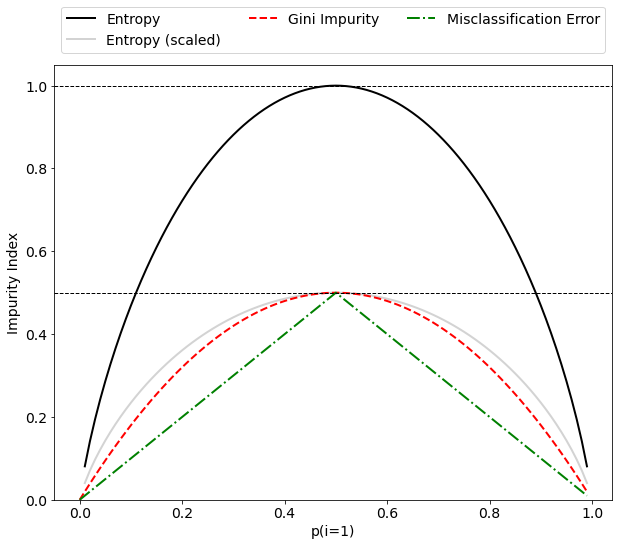

In [ ]:
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
    
x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]

sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                   ['Entropy', 'Entropy (scaled)', 
                   'Gini Impurity', 
                   'Misclassification Error'],
                   ['-', '-', '--', '-.'],
                   ['black', 'lightgray',
                      'red', 'green', 'cyan']):
     line = ax.plot(x, i, label=lab, 
                    linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.05])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
# output_fig('gini and ig')



# 4 Regression Tree

## Hitters.CSV

- [R Documentation](https://www.rdocumentation.org/packages/ISLR/versions/1.2/topics/Hitters)
- [Kaggle Source](https://www.kaggle.com/floser/hitters)
- [Linear Model selection - Hitters dataset](http://rstudio-pubs-static.s3.amazonaws.com/454303_2010275851a046df8796eb2e0da369b5.html)

**LEAGUE** : Player’s league

**ATBAT** : Times at Bat: Number of official plate appearances by a hitter. It counts as an official at-bat as long as the batter does not walk, sacrifice, get hit by a pitch or reach base due to catcher’s interference.

**HITS** : Hits

**HMRUN** : Home Runs

**RUNS** : The number of runs scored by a player. A run is scored by an offensive player who advances from batter to runner and touches first, second, third and home base in that order without being put out.

**RBI** Runs Batted In: A hitter earns a run batted in when he drives in a run via a hit, walk, sacrifice (bunt or fly) fielder’s choice, hit- batsman or on an error (when the official scorer rules that the run would have scored anyway).

**WALKS** : Walks: A walk - base on balls is an award of first base granted to a batter who receives four pitches outside the strike zone.

**YEARS** : Years in the Major Leagues. As far as we can tell, this counts all years a player has actually played in the Major Leagues, not necessarily consectutive. Rookie contracts - 4Yrs.

**CATBAT** : Career Times at Bat

**<u><font color='brown'>CHITS</font></u>** : Career Hits

**CHMRUN** : Career Home Runs

**CRUNS** : Career Runs Scored

**CRBI** : Career Runs Batted In POSITION Player’s position(s). See list of codes used below under Coding for some of the variables. (You are free to recode these as you see fit.)

**PUTOUTS** : Put Outs. A put out is credited when a fielder causes a batter or runner to be, well, put out; e.g., catches the batter’s fly ball, tags a base runner out before he reaches the base, etc.

**ASSISTS** : An assist is credited when a fielder assists in a play causing a player to be put out; e.g.,

**ERRORS** : Errors

**<font color='brown'>SALARY</font>** : 1987 Annual salary on opening day (in 1000$) - Variable of Interest!

**BATAVG** : Batting Average, calculated as 1000*(HITS/ATBAT)

**CBATAVG** : Career Batting Average, calculated as 1000*(HITSC/ATBATC)

**ROOKIE** : Boolean Variable; 1 if years < 4; 0 otherwise

In [ ]:
fetch_file_via_requests(
    DropboxLink('qguf5p681ixky2l', 'hitters.csv'), data_dir )

'/content/drive/My Drive/adventures/tree/hitters.csv'

In [ ]:
hit = pd.read_csv(os.path.join(data_dir, 'hitters.csv'))
hit.drop(['Unnamed: 0'], axis = 1, inplace=True)
hit.dropna(inplace=True)
hit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

## Regularization

- $y = 4\times (x-0.5)^2 + \frac{randn(m,1)}{10}$

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

# 5 Bank Markering Data

- [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- [Bank Marketing Short Version](https://www.kaggle.com/rouseguy/bankbalanced)
- [Bank Marketing Long Version](https://www.kaggle.com/henriqueyamahata/bank-marketing)



1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
-----------
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
-----------------
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
-----------
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)



In [ ]:
fetch_file_via_requests(
    DropboxLink('ahacs515a01ev8r', 'bank-additional-full.csv'), data_dir )
fetch_file_via_requests(
    DropboxLink('iw4jhthgf3ljk9c', 'bank.csv'), data_dir )

## Read data

## EDA

## see results

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
models = [DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier()] 

titles = ['DT',  'NB', 
    'RF', 'AdaBoost', 'Gradient',
     'LightGBM', 'XGBOOST']

## Learning Curve & Overfitting

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


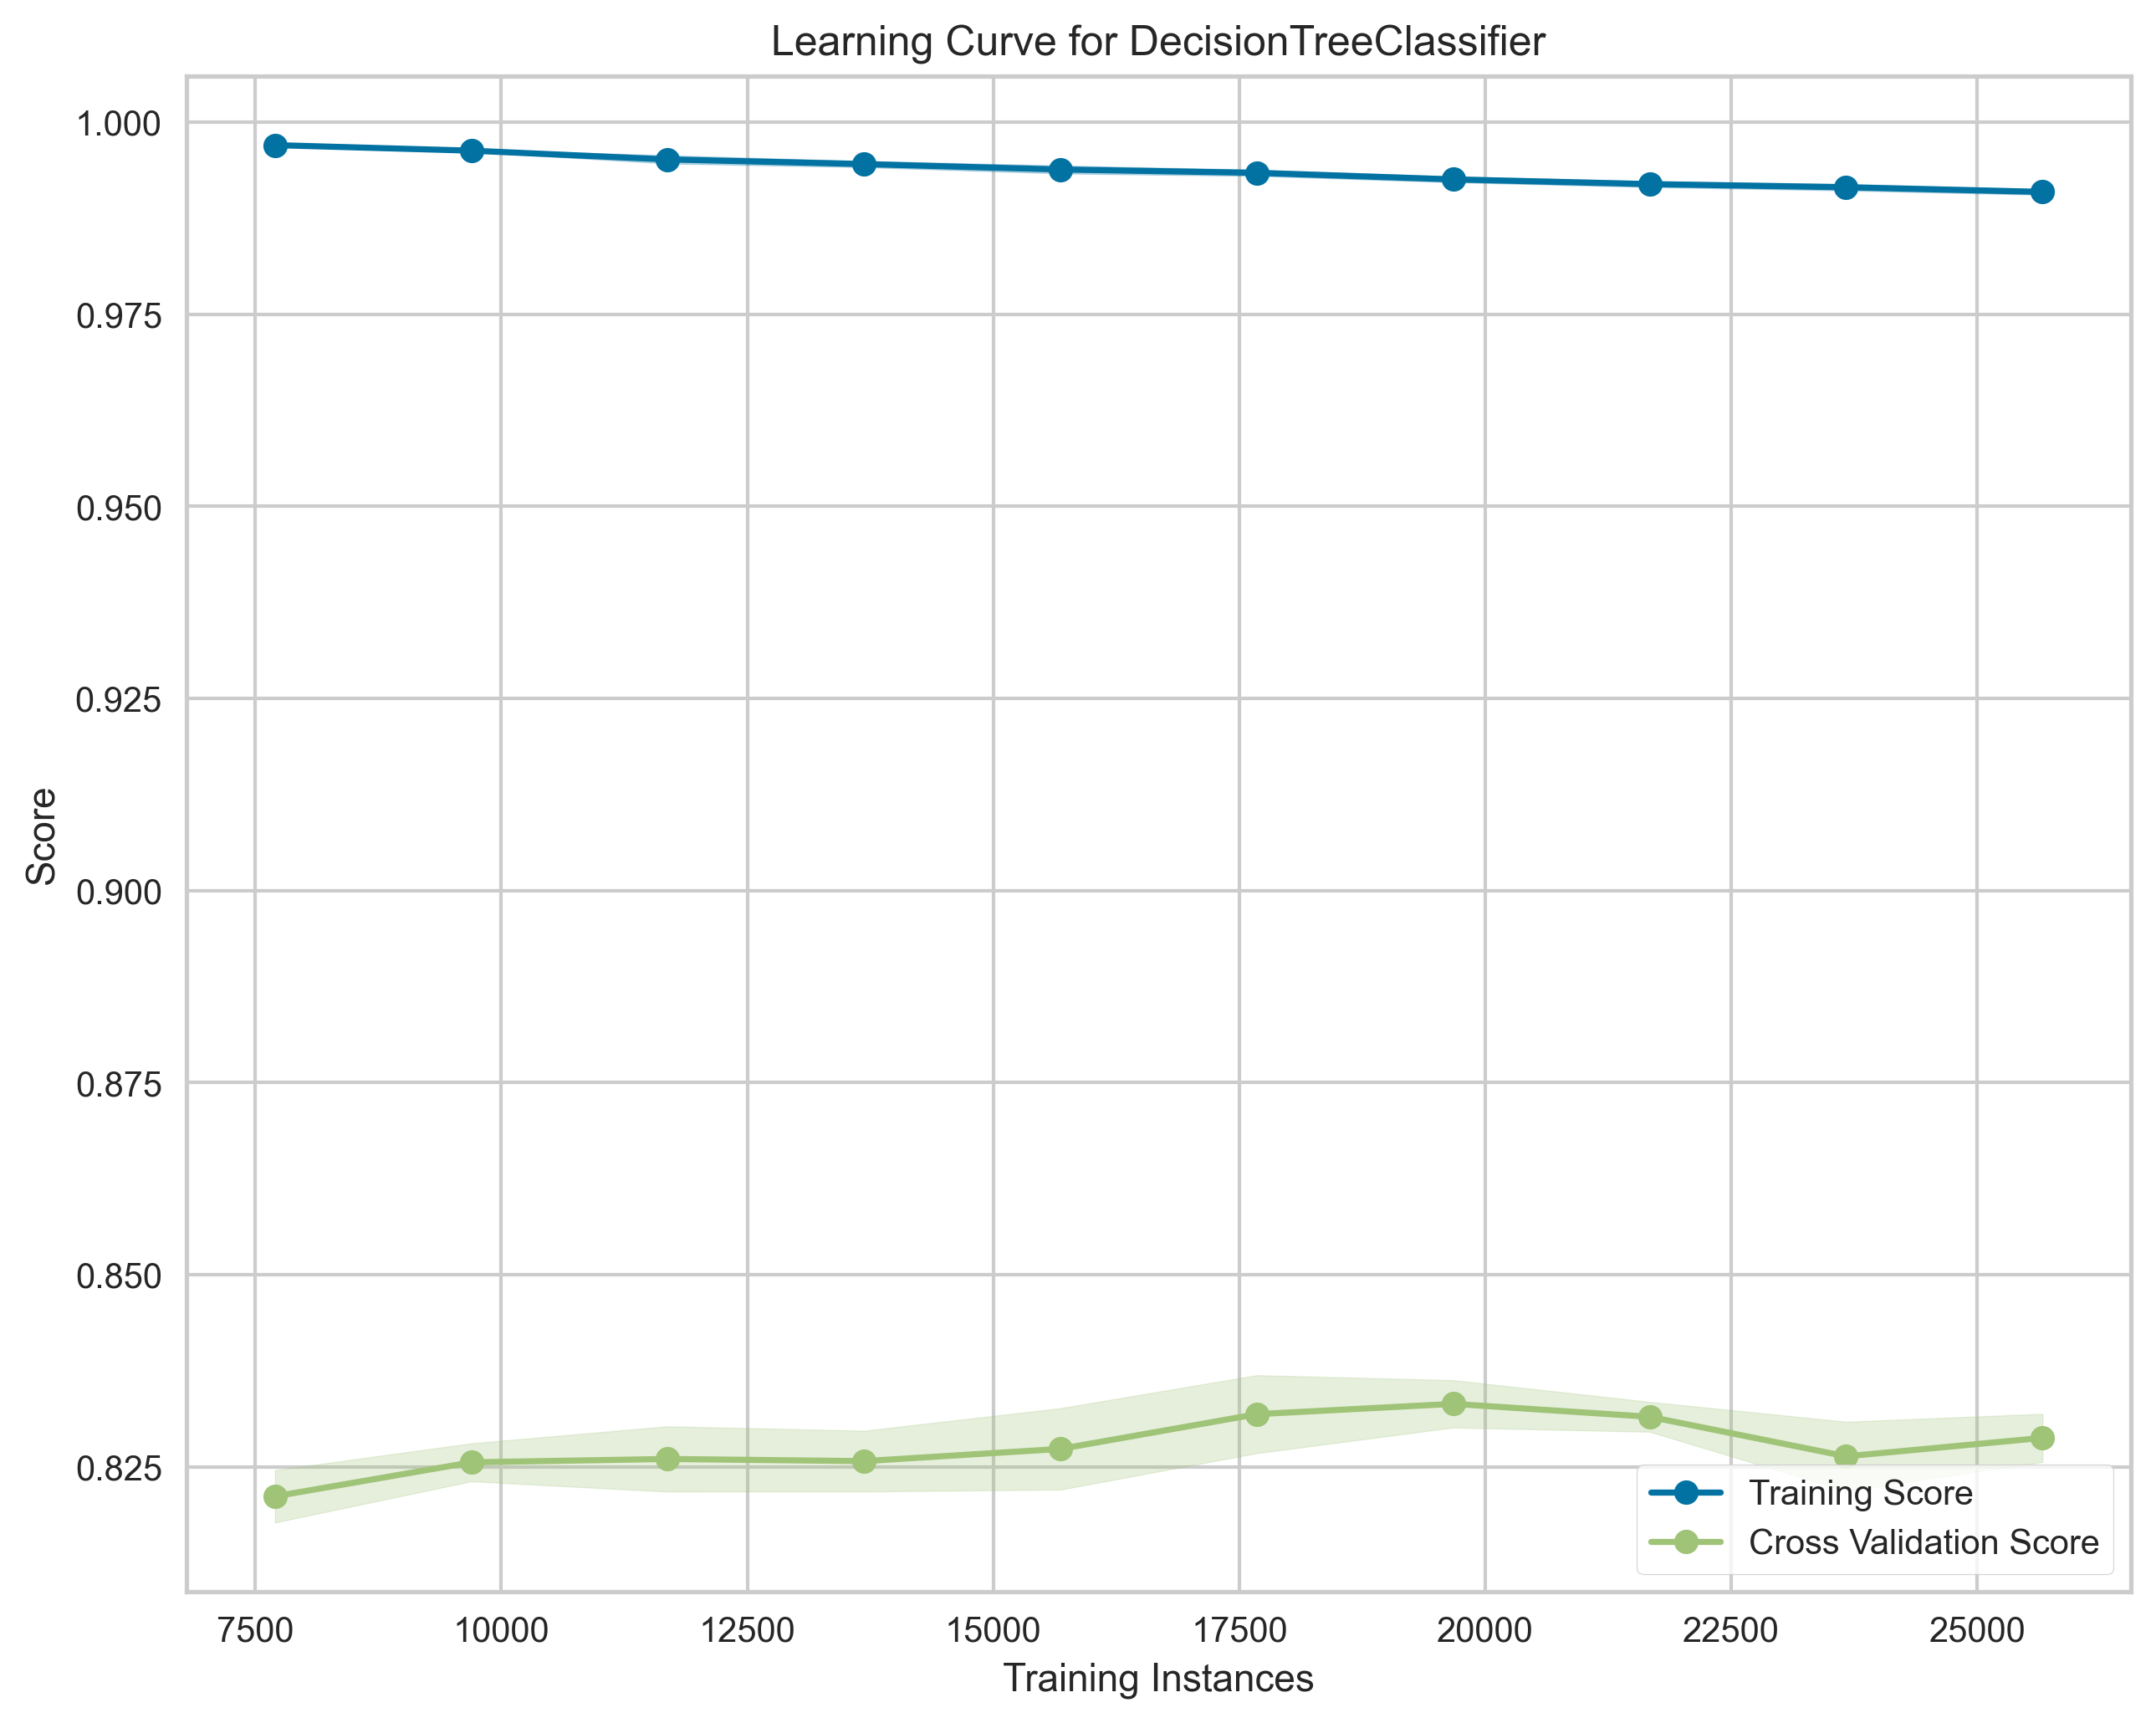

CPU times: user 7 s, sys: 374 ms, total: 7.37 s
Wall time: 7.47 s


<AxesSubplot:title={'center':'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
%%time

from yellowbrick.model_selection import LearningCurve

ax = start_plot_hires(style='whitegrid')
model = DecisionTreeClassifier()
kfold = StratifiedKFold(n_splits=5)
lc = LearningCurve(
    model,
    cv = kfold,
    train_sizes= np.linspace(0.3, 1, 10)
)
lc.fit(X_train, y_train)
lc.show()


## XGBoost

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/index.html)
- [libomp problem](https://stackoverflow.com/questions/61971851/getting-this-simple-problem-while-importing-xgboost-on-jupyter-notebook)

# End of File